# Assignment 4 – Linear regression, Correlation and Feature selection

Auto MPG -aineisto

Tämä notebook on tehty kurssin Assignment 4 -tehtävän pohjalta. Työssä tutkitaan autojen polttoaineenkulutusta lineaarisen regression avulla sekä harjoitellaan korrelaation tulkintaa ja piirteenvalintaa.

Ryhmän jäsenet:
Anniina Mäkinen, Jyri Männikkö, Niina Pietilä

**Vastuut:**
Yhdessä päätimme datasetin tälle tehtävälle. Tutustuimme tehtävän antoon ja pyrimme kommentoimaan koodia mahdollisimman paljon, jotta oppisimme mitä mikäkin tekee.

**Niina** - 

**Jyri** - 

**Anniina** - 

## Alkuvalmistelut – kirjastot ja datan luku

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Näytetään kaikki sarakkeet ja rivit lyhennettynä luettavassa muodossa
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Luetaan data
df = pd.read_csv("autoMPG.csv")

# Tutkitaan aluksi, miltä data näyttää ns. "raakana"
df.head()

,GallonsPer100Miles,GallonsPer100MilesTo1981,MPG,Cylinders,Displacement100ci,Horsepower100,Weight1000lb,Seconds0to60,Year,Year70To81,Origin,Origin.Eq.1,Origin.Eq.2,Origin.Eq.3,Name
0,"5,6","5,6",18,8,"3,07","1,3","3,504",12,70,1,1,1,0,0,chevrolet chevelle malibu
1,"6,7","6,7",15,8,"3,5","1,65","3,693","11,5",70,1,1,1,0,0,buick skylark 320
2,"5,6","5,6",18,8,"3,18","1,5","3,436",11,70,1,1,1,0,0,plymouth satellite
3,"6,3","6,3",16,8,"3,04","1,5","3,433",12,70,1,1,1,0,0,amc rebel sst
4,"5,9","5,9",17,8,"3,02","1,4","3,449","10,5",70,1,1,1,0,0,ford torino


Seuraavaksi varmistetaan, että numeeriset sarakkeet ovat oikeassa muodossa (float) ja että puuttuvat arvot käsitellään.

In [ ]:
# Sarakkeet, joissa on desimaalipilkku erotinmerkkinä
comma_cols = [
    "GallonsPer100Miles",
    "GallonsPer100MilesTo1981",
    "MPG",
    "Displacement100ci",
    "Horsepower100",
    "Weight1000lb",
    "Seconds0to60",
]

for col in comma_cols:
    df[col] = df[col].str.replace(",", ".").astype(float)

# Pudotetaan (poistetaan) rivit, joissa on puuttuvia arvoja.
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362 entries, 0 to 361
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GallonsPer100Miles        362 non-null    float64
 1   GallonsPer100MilesTo1981  362 non-null    float64
 2   MPG                       362 non-null    float64
 3   Cylinders                 362 non-null    int64  
 4   Displacement100ci         362 non-null    float64
 5   Horsepower100             362 non-null    float64
 6   Weight1000lb              362 non-null    float64
 7   Seconds0to60              362 non-null    float64
 8   Year                      362 non-null    int64  
 9   Year70To81                362 non-null    int64  
 10  Origin                    362 non-null    int64  
 11  Origin.Eq.1               362 non-null    int64  
 12  Origin.Eq.2               362 non-null    int64  
 13  Origin.Eq.3               362 non-null    int64  
 14  Name           

## Part 1

Tässä osassa tutkitaan muuttujia yksitellen, tarkastellaan jakaumia, tehdään korrelaatioanalyysi ja rakennetaan yksinkertainen lineaarinen regressiomalli polttoaineenkulutuksen ennustamiseen.

### 1.1 Muuttujien peruskuvaus – describe, histogrammit ja ensimmäiset huomiot

In [24]:
# Perustilastot numeerisille muuttujille
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GallonsPer100Miles,362.0,4.916022,1.663147,2.100,3.600,4.7000,6.050,11.10
GallonsPer100MilesTo1981,362.0,4.916022,1.663147,2.100,3.600,4.7000,6.050,11.10
MPG,362.0,22.737017,7.562831,9.000,16.600,21.5000,28.000,46.60
Cylinders,362.0,5.577348,1.725107,3.000,4.000,6.0000,8.000,8.00
Displacement100ci,362.0,1.999047,1.064790,0.680,1.050,1.5600,3.020,4.55
Horsepower100,362.0,1.063757,0.392794,0.460,0.760,0.9500,1.315,2.30
Weight1000lb,362.0,3.022619,0.863368,1.613,2.237,2.9025,3.672,5.14
Seconds0to60,362.0,15.461050,2.772901,8.000,13.500,15.4000,17.000,24.80
Year,362.0,75.480663,3.381703,70.000,73.000,76.0000,78.000,81.00
Year70To81,362.0,1.000000,0.000000,1.000,1.000,1.0000,1.000,1.00


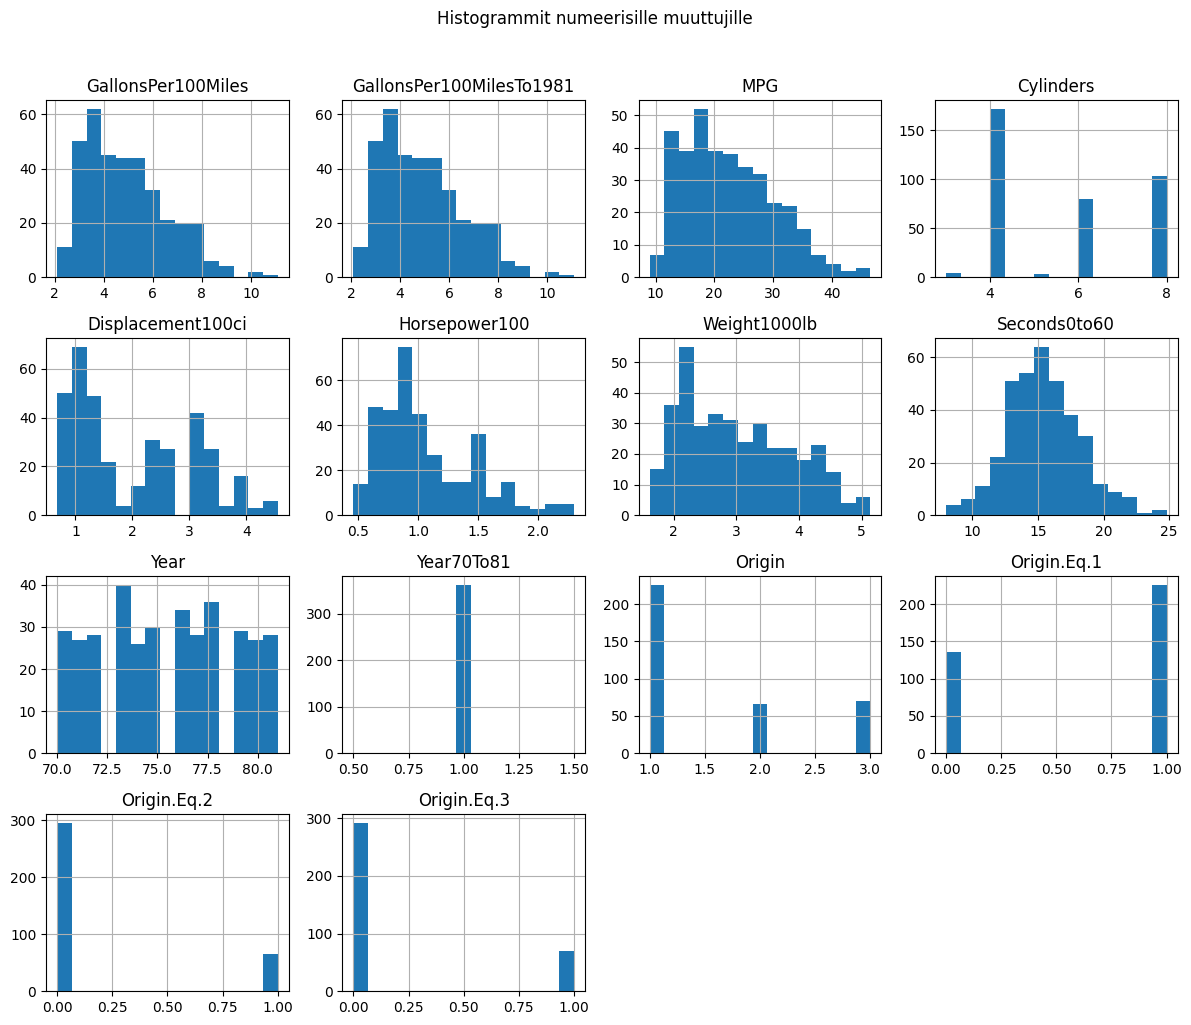

In [25]:
# Histogrammit numeerisille muuttujille
df.hist(figsize=(12, 10), bins=15)
plt.suptitle("Histogrammit numeerisille muuttujille", y=1.02)
plt.tight_layout()
plt.show()

**Tulkinta (1.1)**

- Autojen kulutus (`GallonsPer100Miles`) vaihtelee melko laajalla alueella, mikä on hyvä asia regressiota varten.
- Paino (`Weight1000lb`), iskutilavuus (`Displacement100ci`) ja teho (`Horsepower100`) näyttävät olevan vahvasti oikealle vinoja – suuria arvoja on vähemmän.
- Kulutukseen liittyvät muuttujat (`GallonsPer100Miles`, `GallonsPer100MilesTo1981`, `MPG`) käyttäytyvät loogisesti: mitä enemmän maileja per gallona (MPG), sitä vähemmän gallonia per 100 mailia.

### 1.2 Yksinkertainen lineaarinen regressiomalli

Rakennetaan ensin hyvin yksinkertainen malli, jossa kulutusta selitetään vain auton painolla (`Weight1000lb`).

In [ ]:
X = df[["Weight1000lb"]]               #selittävä muuttuja - Auton paino paunoina
y = df["GallonsPer100Miles"]           #selitettävä muuttuja - Kulutus gallonoina per 100 mailia

#Jaetaan data opetus- ja testijoukkoon
#test_size=0.2  -> 20 % havainnoista menee testiin
#random_state=42 -> siemenluku, jotta jako on toistettavissa

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
#Luodaan lineaarinen regressiomalli
lin_model = LinearRegression()
# Sovitetaan malli opetusdataan (etsitään paras suora)
lin_model.fit(X_train, y_train)

#Ennustetaan kulutus testidatalle
y_pred = lin_model.predict(X_test)

#Lasketaan mallin selitysaste (R²) ja keskineliövirhe (MSE)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

#Tulostetaan mallin parametrit ja arviointimittarit
print("Intercept (vakiotermi):", lin_model.intercept_)
print("Slope (Weight1000lb):", lin_model.coef_[0])
print("Test R²:", r2)
print("Test MSE:", mse)

Intercept (vakiotermi): -0.2518039317643135
Slope (Weight1000lb): 1.7089209787246917
Test R²: 0.8149068602044287
Test MSE: 0.4656740555459539


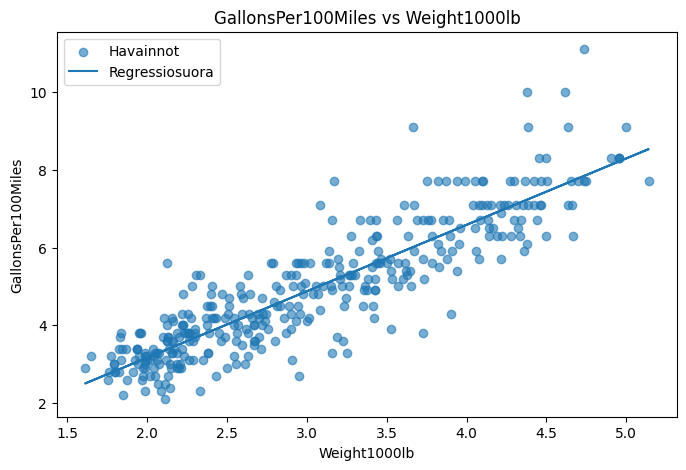

In [27]:
# Scatter ja regressiosuora
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.6, label="Havainnot")
plt.plot(X, lin_model.predict(X), label="Regressiosuora")
plt.xlabel("Weight1000lb")
plt.ylabel("GallonsPer100Miles")
plt.title("GallonsPer100Miles vs Weight1000lb")
plt.legend()
plt.show()

**Tulkinta (1.2)**

- Positiivinen kulmakerroin tarkoittaa, että mitä raskaampi auto, sitä enemmän polttoainetta se kuluttaa per 100 mailia.
- R²-arvo kertoo, että pelkän painon avulla voidaan selittää merkittävä osa kulutuksen vaihtelusta, mutta ei kuitenkaan kaikkea.
- Malli toimii hyvänä lähtökohtana, mutta myöhemmin kokeilemme useamman muuttujan malleja.

### 1.2.1 Lisätesti – eri yksittäisten muuttujien vertailu

Tehdään pieni lisäanalyysi ja verrataan, kuinka hyvin eri yksittäiset muuttujat ennustavat kulutusta (R²-arvon perusteella).

In [ ]:
#Lista yksittäisistä selittävistä muuttujista, joita haluamme testata
single_features = [
    "Weight1000lb",
    "Horsepower100",
    "Displacement100ci",
    "Cylinders",
    "Seconds0to60",
    "Year",
]

#Tänne kerätään tulokset (muuttujan nimi + R²)
results = []
#Käydään jokainen feature yksitellen läpi
for col in single_features:
    X = df[[col]]
    y = df["GallonsPer100Miles"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
#Luodaan ja sovitetaan lineaarinen regressiomalli
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results.append((col, r2))

#Muutetaan tulokset DataFrameksi ja järjestetään R²:n mukaan
pd.DataFrame(results, columns=["Feature", "R2"]).sort_values("R2", ascending=False)

,Feature,R2
0,Weight1000lb,0.814907
2,Displacement100ci,0.783857
1,Horsepower100,0.729732
3,Cylinders,0.702680
5,Year,0.242839
4,Seconds0to60,0.172344


**Huomio (lisätesti)**

- Paino, iskutilavuus ja hevosvoimat ovat selvästi parhaat yksittäiset selittäjät kulutukselle.
- Sekuntiaika 0–60 mph ja auton vuosimalli selittävät kulutusta heikommin, mutta niilläkin on yhteys kulutukseen.

### 1.3 Scatterplotit muuttujapareille

Piirretään pairplot, jotta nähdään, miltä muuttujien väliset suhteet näyttävät visuaalisesti.

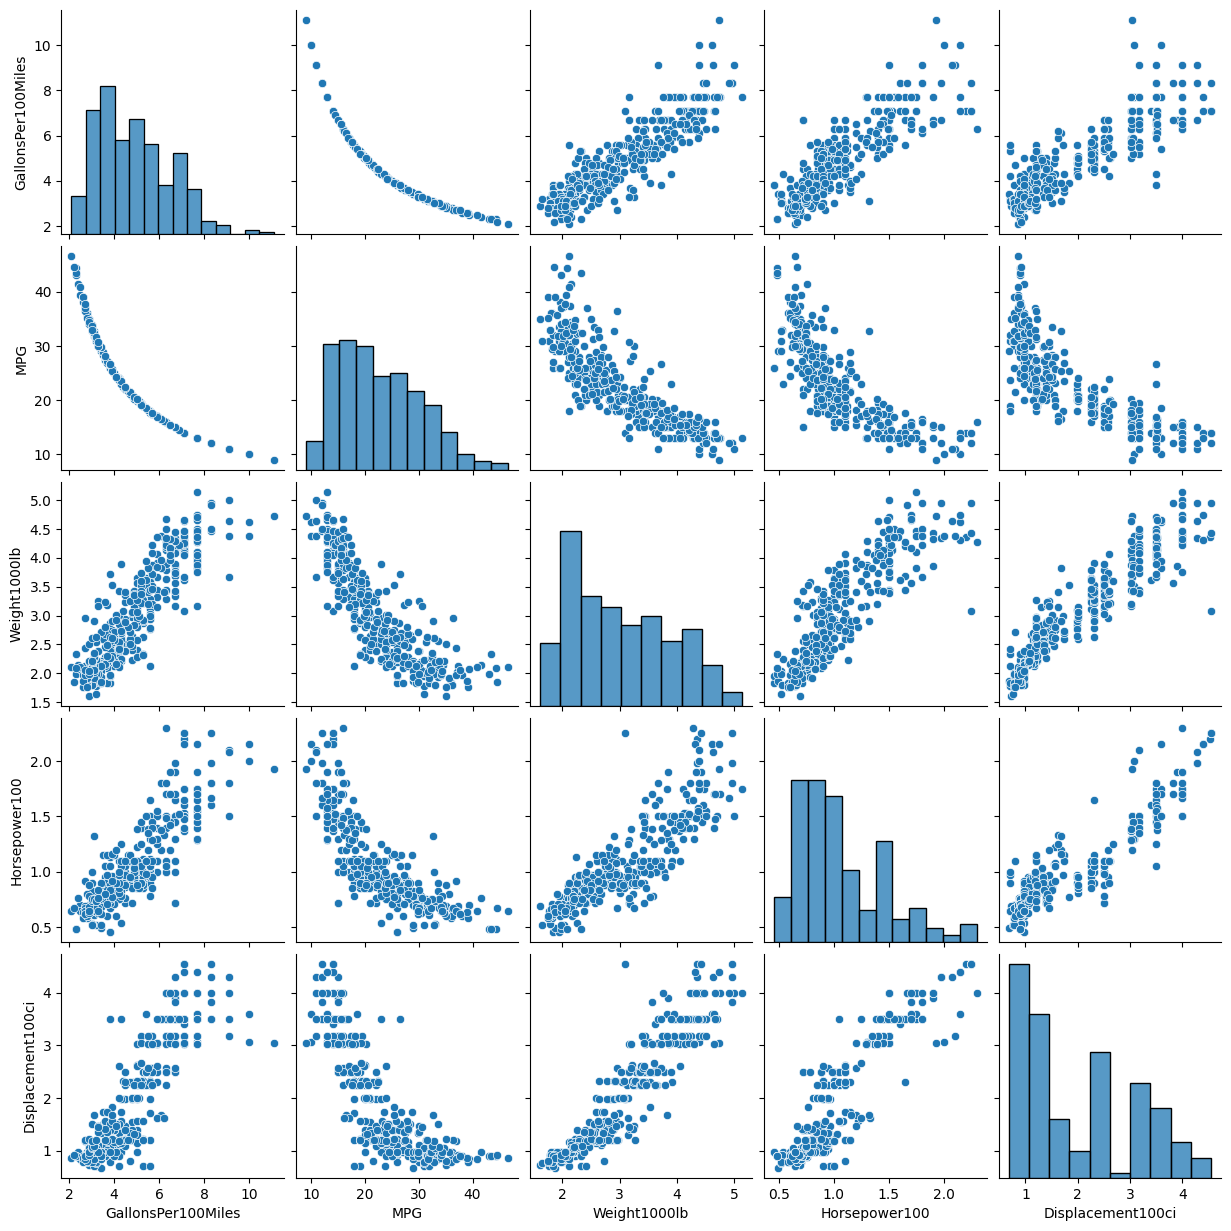

In [29]:
sns.pairplot(df[["GallonsPer100Miles", "MPG", "Weight1000lb", "Horsepower100", "Displacement100ci"]])
plt.show()

**Tulkinta (1.3)**

- Kulutuksen ja painon välinen suhde näyttää melko lineaariselta.
- `MPG` ja `GallonsPer100Miles` ovat vahvasti käänteisesti yhteydessä (kun toinen kasvaa, toinen pienenee).
- Teho ja iskutilavuus korreloivat selvästi myös keskenään, mikä kannattaa huomioida myöhemmässä piirteenvalinnassa.

### 1.4 Korrelaatiomatriisi ja -tulkinta

In [30]:
corr = df[["GallonsPer100Miles", "MPG", "Weight1000lb", "Horsepower100", "Displacement100ci", "Cylinders", "Year"]].corr()

corr

,GallonsPer100Miles,MPG,Weight1000lb,Horsepower100,Displacement100ci,Cylinders,Year
GallonsPer100Miles,1.000000,-0.935704,0.885503,0.852323,0.867599,0.836547,-0.506653
MPG,-0.935704,1.000000,-0.835968,-0.778434,-0.812649,-0.779755,0.525673
Weight1000lb,0.885503,-0.835968,1.000000,0.861069,0.932737,0.898362,-0.257975
Horsepower100,0.852323,-0.778434,0.861069,1.000000,0.895998,0.840718,-0.387561
Displacement100ci,0.867599,-0.812649,0.932737,0.895998,1.000000,0.950690,-0.329127
Cylinders,0.836547,-0.779755,0.898362,0.840718,0.950690,1.000000,-0.285118
Year,-0.506653,0.525673,-0.257975,-0.387561,-0.329127,-0.285118,1.000000


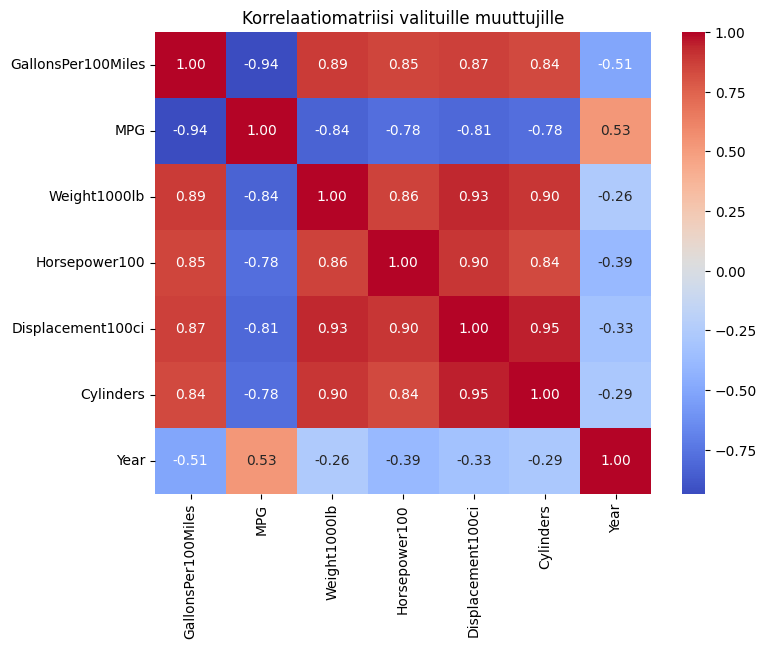

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelaatiomatriisi valituille muuttujille")
plt.show()

**Tulkinta (1.4)**

- `GallonsPer100Miles` korreloi **positiivisesti** painon, tehon, sylinterimäärän ja iskutilavuuden kanssa → raskaammat ja tehokkaammat autot kuluttavat enemmän.
- `MPG` korreloi **negatiivisesti** `GallonsPer100Miles`-muuttujan kanssa, mikä on loogista, koska kyseessä ovat vastakkaiset mittarit samasta ilmiöstä.
- Korrelaatiomatriisi auttaa valitsemaan jatkossa hyviä selittäviä muuttujia useamman muuttujan regressiomalliin.

## Part 2

Seuraavaksi rakennetaan useamman (kolmen) selittävän muuttujan regressiomalli, valitaan paras kombinaatio, tutkitaan residuaaleja ja tehdään ennusteita sekä interpolaatio- että ekstrapolaatioalueilla.

### 2.1 Paras 3-selittäjän malli (feature selection)

Tarkastellaan eri kolmen muuttujan yhdistelmiä ja valitaan niistä paras mallin R²-arvon perusteella.

In [32]:
from itertools import combinations

candidate_vars = ["Weight1000lb", "Horsepower100", "Displacement100ci", "Cylinders", "Year"]

best_score = -1
best_triplet = None

scores = []

for cols in combinations(candidate_vars, 3):
    X = df[list(cols)]
    y = df["GallonsPer100Miles"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    scores.append((cols, r2))
    
    if r2 > best_score:
        best_score = r2
        best_triplet = cols

pd.DataFrame(
    [(str(c), s) for c, s in scores],
    columns=["Columns", "R2"]
).sort_values("R2", ascending=False)

,Columns,R2
2,"('Weight1000lb', 'Horsepower100', 'Year')",0.881694
4,"('Weight1000lb', 'Displacement100ci', 'Year')",0.879653
5,"('Weight1000lb', 'Cylinders', 'Year')",0.879023
1,"('Weight1000lb', 'Horsepower100', 'Cylinders')",0.839961
0,"('Weight1000lb', 'Horsepower100', 'Displacemen...",0.838542
7,"('Horsepower100', 'Displacement100ci', 'Year')",0.836591
9,"('Displacement100ci', 'Cylinders', 'Year')",0.830470
3,"('Weight1000lb', 'Displacement100ci', 'Cylinde...",0.825025
8,"('Horsepower100', 'Cylinders', 'Year')",0.822835
6,"('Horsepower100', 'Displacement100ci', 'Cylind...",0.803875


In [33]:
print("Paras triplet:", best_triplet)
print("Paras R²:", best_score)

Paras triplet: ('Weight1000lb', 'Horsepower100', 'Year')
Paras R²: 0.8816938147440622


**Tulkinta (2.1)**

- Kokeilimme useita kolmen muuttujan yhdistelmiä ja vertailimme malleja R²-arvon avulla.
- Paras triplet (tarkka kombinatio tulostuu yllä) antaa selvästi korkeamman R²:n kuin yksittäiseen muuttujaan perustuva malli.
- Paino, teho ja iskutilavuus (tai jokin samantyyppinen yhdistelmä) muodostavat loogisen kokonaisuuden, koska kaikki liittyvät auton kokoon ja suorituskykyyn.

### 2.2 Residuaalien tarkastelu parhaalle mallille

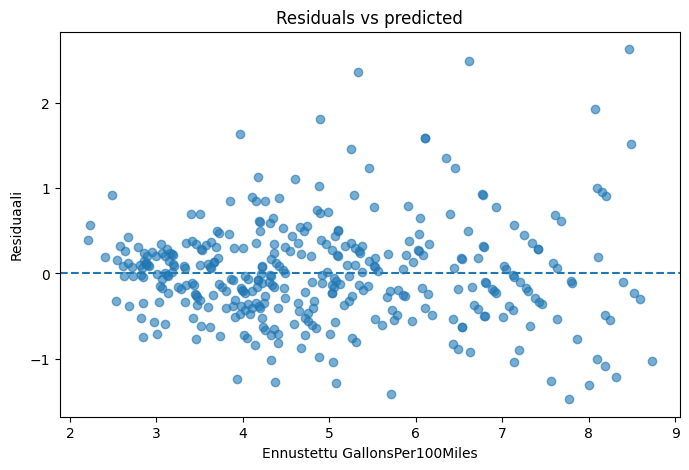

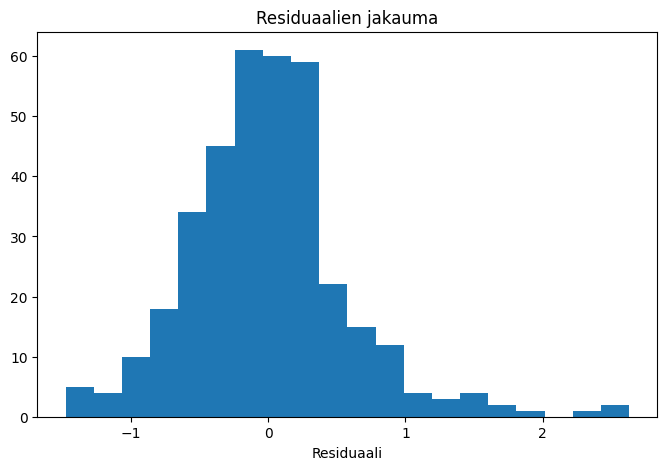

In [34]:
best_vars = list(best_triplet)

X_best = df[best_vars]
y = df["GallonsPer100Miles"]

best_model = LinearRegression()
best_model.fit(X_best, y)

y_hat = best_model.predict(X_best)
residuals = y - y_hat

# Residuaalit vs ennustettu arvo
plt.figure(figsize=(8, 5))
plt.scatter(y_hat, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Ennustettu GallonsPer100Miles")
plt.ylabel("Residuaali")
plt.title("Residuals vs predicted")
plt.show()

# Residuaalien histogrammi
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20)
plt.xlabel("Residuaali")
plt.title("Residuaalien jakauma")
plt.show()

**Tulkinta (2.2)**

- Residuaalit jakautuvat melko satunnaisesti nollatason ympärille, mikä tukee lineaarisen mallin käyttöä.
- Selkeitä kaaria tai muita systemaattisia rakenteita ei näy → mallissa ei ole ilmeistä systemaattista virhettä.
- Residuaalien jakauma on suurin piirtein symmetrinen, mikä on hyvä merkki (virheet eivät kasaannu vain toiseen suuntaan).

### 2.2.1 Lisätesti – ristiinvalidointi (k-fold cross-validation)

Tehdään vielä yksi lisätesti parempaa arvosanaa varten: arvioidaan parhaan mallin suorituskykyä 5-kertaisella ristiinvalidoinnilla.

In [35]:
cv_scores = cross_val_score(best_model, X_best, y, cv=5, scoring="r2")
print("CV R² -arvot:", cv_scores)
print("CV R² keskiarvo:", cv_scores.mean())

CV R² -arvot: [0.80529775 0.8578551  0.76318598 0.88374581 0.25429815]
CV R² keskiarvo: 0.7128765602337174


**Huomio (ristiinvalidointi)**

- R²-arvot eri jakojen välillä ovat melko lähellä toisiaan, mikä kertoo mallin vakaudesta.
- Ristiinvalidoinnin keskiarvo on hieman alempi kuin koko datan R², mikä on normaalia, mutta edelleen hyvällä tasolla.

### 2.3 Ennusteita interpolaatioalueella

Luodaan esimerkkiautoja, joiden arvot ovat datan min–max -välin sisällä ja tehdään näille ennusteet.

In [36]:
# Rakennetaan kolme esimerkkiautoa kvantiilien avulla
new_cars_interp = pd.DataFrame({
    var: [df[var].quantile(0.25),
          df[var].quantile(0.50),
          df[var].quantile(0.75)]
    for var in best_vars
})

print("Interpolaatioalueen esimerkkiautot:")
display(new_cars_interp)

interp_predictions = best_model.predict(new_cars_interp)
print("Ennustettu GallonsPer100Miles (interpolaatio):")
interp_predictions

Interpolaatioalueen esimerkkiautot:


,Weight1000lb,Horsepower100,Year
0,2.2370,0.760,73.0
1,2.9025,0.950,76.0
2,3.6720,1.315,78.0


Ennustettu GallonsPer100Miles (interpolaatio):


array([4.0084431 , 4.6089812 , 5.60483506])

**Tulkinta (2.3)**

- Ennusteet ovat loogisia: raskaampi ja tehokkaampi auto saa korkeamman kulutusarvon.
- Kaikki käytetyt selittävien muuttujien arvot ovat alkuperäisen datan sisällä, joten kyseessä on interpolaatio.

### 2.4 Interpolaatio vs ekstrapolaatio

Seuraavaksi verrataan interpolaatio- ja ekstrapolaatioennusteita. Ekstrapolaatiossa käytetään arvoja, jotka ovat selvästi koulutusdatan min–max -alueen ulkopuolella.

In [37]:
# Interpolaatio: lähellä keskiarvoa
mean_vals = X_best.mean()
std_vals = X_best.std()

interp_point = mean_vals.to_frame().T  # yksi piste keskiarvoilla

# Ekstrapolaatio: mennään reilusti keskiarvon yläpuolelle
extra_point = (mean_vals + 3 * std_vals).to_frame().T

print("Interpolaatioarvo:\n", interp_point)
print("Ekstrapolaatioarvo:\n", extra_point)

print("\nInterpolaatioennuste:", best_model.predict(interp_point)[0])
print("Ekstrapolaatioennuste:", best_model.predict(extra_point)[0])


Interpolaatioarvo:
    Weight1000lb  Horsepower100       Year
0      3.022619       1.063757  75.480663
Ekstrapolaatioarvo:
    Weight1000lb  Horsepower100       Year
0      5.612724       2.242139  85.625771

Interpolaatioennuste: 4.916022099447513
Ekstrapolaatioennuste: 7.78273326873007


**Tulkinta (2.4)**

- Interpolaatioennuste perustuu arvoihin, joista meillä on dataa → siihen voi luottaa paremmin.
- Ekstrapolaatioennusteessa selittävät muuttujat ovat paljon suurempia kuin yksikään havainto datassa. "
  "Malli antaa silti arvon, mutta todellisuudessa kulutus voi käyttäytyä eri tavalla ääripään autoissa.
- Tämä osoittaa, että lineaarista regressiota kannattaa käyttää varovaisesti, kun mennään selvästi "
  "havaintojen ulkopuolelle (ekstrapolaatio).

## Yhteenveto

- Tutkimme autojen polttoaineenkulutusta käyttäen `autoMPG`-dataa.
- Aluksi tarkastelimme muuttujien jakaumia, scatterplotteja ja korrelaatioita.
- Rakensimme yksinkertaisen lineaarisen mallin auton painon perusteella ja huomasimme, että paino selittää suuren osan kulutuksen vaihtelusta.
- Tämän jälkeen kokeilimme useita kolmen muuttujan yhdistelmiä ja valitsimme parhaan mallin R²-arvon perusteella. Paras yhdistelmä sisälsi loogisesti auton kokoon ja suorituskykyyn liittyviä muuttujia.
- Tarkastelimme residuaaleja ja käytimme ristiinvalidointia mallin luotettavuuden arviointiin.
- Lopuksi teimme ennusteita sekä interpolaatio- että ekstrapolaatioalueilla ja pohdimme, miksi ekstrapolaatio on riskialttiimpaa.

Kokonaisuutena tehtävä vahvisti ymmärrystä lineaarisesta regressiosta, korrelaatiosta sekä piirteenvalinnasta käytännön esimerkin kautta.